# Needle Collection in NYC Parks: A Data Exploration

By Aaron Potts

### Setup

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import shapely as sh
from shapely import wkt
import matplotlib.pyplot as plt
import plotly.express as px


Our data comes from the [NYC Parks Syringe Litter Data Collection](https://data.cityofnewyork.us/browse?Data-Collection_Data-Collection=NYC+Parks+Syringe+Litter&q=), taking most of our data from the Summary of Syringe Data in NYC Parks, and location data from the Parks Properties sheets. The data covers mostly certain portions of Manhattan and the Bronx that are the responsibility of the NYC Parks Department, the Parks Department Bloodborn Pathogen Crew, the Washington Heights Corner Project, and New York Harm Reduction Educators, the latter two of which have now merged and are now [OnPointNYC](https://onpointnyc.org/). It does not contain personally identifying information, and in fact lacks any staffing information beyond broad attributions to different groups.

In [2]:
sy = pd.read_csv("Data/Summary_of_Syringe_Data_in_NYC_Parks.csv")
pp = pd.read_csv("Data/Parks_Properties.csv")

In [3]:
pp = pp[['GISPROPNUM', 'multipolygon']]

In [4]:
pp.head(10)

GISPROPNUM                                       multipolygon
0      Q084A  MULTIPOLYGON (((-73.8587476480729 40.767414466...
1       Q498  MULTIPOLYGON (((-73.82218300936414 40.59892072...
2       Q346  MULTIPOLYGON (((-73.72738293199147 40.75605209...
3       B510  MULTIPOLYGON (((-73.91598050092 40.66927372409...
4       B058  MULTIPOLYGON (((-73.9529286105069 40.720436278...
5       B502  MULTIPOLYGON (((-73.94519019107632 40.68617686...
6      X195E  MULTIPOLYGON (((-73.84374321952677 40.82901804...
7       B426  MULTIPOLYGON (((-73.9396631946347 40.712601061...
8       B425  MULTIPOLYGON (((-73.93893539617332 40.71323418...
9       Q454  MULTIPOLYGON (((-73.73905463825886 40.65284962...

In [5]:
pp.isnull().sum()

GISPROPNUM      0
multipolygon    0
dtype: int64

In [6]:
#use Shapely to find the centroid of the multipolygon, and apply that to the new 'centroid' column
#This is a growth area and could be done less problematically
pp['centroid'] = pp.apply(lambda x: sh.wkt.loads(x['multipolygon']).centroid, axis=1)

In [7]:
#create latitude and longitude for later mapping, by extracting x and y values from the centroid
#Looks like it works by using the .x and .y methods, which might be available through the centroid object in Shapely
#Well Known Text format reverses latitude and longitude
pp['latitude'] = pp['centroid'].apply(lambda x: x.y)
pp['longitude'] = pp['centroid'].apply(lambda x: x.x)

In [10]:
pp = pp.drop(columns = ["multipolygon" , "centroid"])

KeyError: "['multipolygon', 'centroid'] not found in axis"

In [11]:
pp.head(10)

GISPROPNUM   latitude  longitude
0      Q084A  40.753159 -73.853168
1       Q498  40.598530 -73.822995
2       Q346  40.756623 -73.727964
3       B510  40.669380 -73.916197
4       B058  40.720857 -73.951842
5       B502  40.686290 -73.945212
6      X195E  40.829058 -73.843833
7       B426  40.712737 -73.939715
8       B425  40.713300 -73.939052
9       Q454  40.648779 -73.742196

In [12]:
sy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25575 entries, 0 to 25574
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   response_id      25575 non-null  object 
 1   gispropnum       25452 non-null  object 
 2   omppropid        25452 non-null  object 
 3   collected_date   25575 non-null  object 
 4   time_of_day      12082 non-null  object 
 5   year             25575 non-null  int64  
 6   month            25575 non-null  int64  
 7   month_text       25575 non-null  object 
 8   week             25575 non-null  int64  
 9   group            25575 non-null  object 
 10  location         25452 non-null  object 
 11  ground_syringes  19300 non-null  float64
 12  kiosk_syringes   3921 non-null   float64
 13  total_syringes   23627 non-null  float64
 14  kiosk_number     6625 non-null   float64
 15  kiosk_type       6291 non-null   object 
 16  precinct         25450 non-null  float64
 17  borough     

In [12]:
#data cleaning
# Two particular entries were fixed
# Got weird errors with week table, etc.
# Datetime is to allow for week + 1 checks later

sy = sy.drop(columns = ['omppropid', 'month', 'kiosk_number', 'kiosk_type', 'district', 'source', 'created_date', 'week', 'year'])
sy.dropna(subset=['gispropnum'], inplace=True)
sy['collected_date'] = pd.to_datetime(sy['collected_date'])
sy.loc[sy['location'] == 'McNally Plaza', 'precinct'] = 34
sy.loc[sy['location'] == 'Bronx Park', 'precinct'] = 52
sy['time_of_day'].fillna("Daily", inplace = True)

In [13]:
#week correction row
for i, row in sy.iterrows():
    if row['week'] == 53:
        sy.at[i,'week'] = 1
        sy.at[i,'year'] += 1

In [14]:
sy.head(10)

response_id gispropnum collected_date time_of_day  year month_text week  \
46    M-000698       M019     2021-06-15          AM  2021        Jun   25   
47    M-000710       M019     2021-07-20          AM  2021        Jul   30   
48    M-000718       M019     2021-07-04          AM  2021        Jul   28   
49    M-000983       M019     2021-10-01          PM  2021        Oct   40   
50    M-001026       M019     2021-10-13          AM  2021        Oct   42   
51    M-000971       M019     2021-09-30          AM  2021        Sep   40   
52    M-000961       M019     2021-09-29          AM  2021        Sep   40   
53    M-000951       M019     2021-09-28          AM  2021        Sep   40   
54    M-000942       M019     2021-09-27          AM  2021        Sep   40   
55    M-000932       M019     2021-09-25          AM  2021        Sep   39   

    group            location  ground_syringes  kiosk_syringes  \
46  Parks  Coleman Playground              2.0             NaN   
47  Parks  Coleman Playground              2.0             NaN   
48  Parks  Coleman Playground              3.0             NaN   
49  Parks  Coleman Playground             16.0             NaN   
50  Parks  Coleman Playground              NaN             NaN   
51  Parks  Coleman Playground              NaN             NaN   
52  Parks  Coleman Playground              NaN             NaN   
53  Parks  Coleman Playground              1.0             NaN   
54  Parks  Coleman Playground              NaN             NaN   
55  Parks  Coleman Playground              NaN             NaN   

    total_syringes  precinct    borough property_type kiosk_site  
46             2.0         5  Manhattan          PARK      False  
47             2.0         5  Manhattan          PARK      False  
48             3.0         5  Manhattan          PARK      False  
49            16.0         5  Manhattan          PARK      False  
50             NaN         5  Manhattan          PARK      False  
51             NaN         5  Manhattan          PARK      False  
52             NaN         5  Manhattan          PARK      False  
53             1.0         5  Manhattan          PARK      False  
54             NaN         5  Manhattan          PARK      False  
55             NaN         5  Manhattan          PARK      False

In [15]:
sy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23954 entries, 46 to 24058
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   response_id      23954 non-null  object        
 1   gispropnum       23954 non-null  object        
 2   collected_date   23954 non-null  datetime64[ns]
 3   time_of_day      23954 non-null  object        
 4   year             23954 non-null  object        
 5   month_text       23954 non-null  object        
 6   week             23954 non-null  object        
 7   group            23954 non-null  object        
 8   location         23954 non-null  object        
 9   ground_syringes  17679 non-null  float64       
 10  kiosk_syringes   3921 non-null   float64       
 11  total_syringes   22006 non-null  float64       
 12  precinct         23954 non-null  int32         
 13  borough          23954 non-null  object        
 14  property_type    23954 non-null  obje

In [16]:
sy.describe()

ground_syringes  kiosk_syringes  total_syringes      precinct
count     17679.000000     3921.000000    22006.000000  23954.000000
mean         31.685672       33.000000       31.335272     38.060908
std          89.581992       71.884566       86.993600     10.755392
min           1.000000        1.000000        0.000000      1.000000
25%           5.000000        3.000000        4.000000     34.000000
50%          11.000000       10.000000       10.000000     40.000000
75%          28.000000       30.000000       27.000000     44.000000
max        7000.000000     1000.000000     7000.000000    122.000000

In [17]:
sy.describe(include='all')

C:\Users\capta\AppData\Local\Temp\ipykernel_62804\2510426743.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  sy.describe(include='all')


response_id gispropnum       collected_date time_of_day     year  \
count        23954      23954                23954       23954  23954.0   
unique       23954        280                 1832           3      7.0   
top       M-000698       M037  2019-01-22 00:00:00       Daily   2022.0   
freq             1       6632                  104       13474   7574.0   
first          NaN        NaN  2017-01-01 00:00:00         NaN      NaN   
last           NaN        NaN  2023-02-13 00:00:00         NaN      NaN   
mean           NaN        NaN                  NaN         NaN      NaN   
std            NaN        NaN                  NaN         NaN      NaN   
min            NaN        NaN                  NaN         NaN      NaN   
25%            NaN        NaN                  NaN         NaN      NaN   
50%            NaN        NaN                  NaN         NaN      NaN   
75%            NaN        NaN                  NaN         NaN      NaN   
max            NaN        NaN                  NaN         NaN      NaN   

       month_text     week  group         location  ground_syringes  \
count       23954  23954.0  23954            23954     17679.000000   
unique         12     52.0      3              271              NaN   
top           Jan     43.0  Parks  Highbridge Park              NaN   
freq         2267    581.0  12056             6632              NaN   
first         NaN      NaN    NaN              NaN              NaN   
last          NaN      NaN    NaN              NaN              NaN   
mean          NaN      NaN    NaN              NaN        31.685672   
std           NaN      NaN    NaN              NaN        89.581992   
min           NaN      NaN    NaN              NaN         1.000000   
25%           NaN      NaN    NaN              NaN         5.000000   
50%           NaN      NaN    NaN              NaN        11.000000   
75%           NaN      NaN    NaN              NaN        28.000000   
max           NaN      NaN    NaN              NaN      7000.000000   

        kiosk_syringes  total_syringes      precinct borough property_type  \
count      3921.000000    22006.000000  23954.000000   23954         23954   
unique             NaN             NaN           NaN       4             4   
top                NaN             NaN           NaN   Bronx          PARK   
freq               NaN             NaN           NaN   15952         17256   
first              NaN             NaN           NaN     NaN           NaN   
last               NaN             NaN           NaN     NaN           NaN   
mean         33.000000       31.335272     38.060908     NaN           NaN   
std          71.884566       86.993600     10.755392     NaN           NaN   
min           1.000000        0.000000      1.000000     NaN           NaN   
25%           3.000000        4.000000     34.000000     NaN           NaN   
50%          10.000000       10.000000     40.000000     NaN           NaN   
75%          30.000000       27.000000     44.000000     NaN           NaN   
max        1000.000000     7000.000000    122.000000     NaN           NaN   

       kiosk_site  
count       23557  
unique          2  
top          True  
freq        19089  
first         NaN  
last          NaN  
mean          NaN  
std           NaN  
min           NaN  
25%           NaN  
50%           NaN  
75%           NaN  
max           NaN

In [18]:
sy.isnull().sum()

response_id            0
gispropnum             0
collected_date         0
time_of_day            0
year                   0
month_text             0
week                   0
group                  0
location               0
ground_syringes     6275
kiosk_syringes     20033
total_syringes      1948
precinct               0
borough                0
property_type          0
kiosk_site           397
dtype: int64

In [19]:

sy1 = sy.join(pp.set_index('GISPROPNUM'), on='gispropnum', how='left')

In [20]:
#creates a location map we can use later- the aggregation of longitude and latitude was necessary to make it work. Some location granularity is lost

location_map = sy1.groupby('location').agg({'longitude': 'mean', 'latitude': 'mean'}).reset_index()

In [21]:
sy1.to_csv("Syringe Location Data.csv")
location_map.to_csv("Syringe Location Key.csv")

## Background

Starting in 2018, in an effort to address the increasing problem of discarded needles used in the injection of intravenous drugs, NYC Parks in cooperation with the Department of Health and Mental Hygiene [deployed sharps disposal kiosks](https://www.nycgovparks.org/news/press-releases?id=21566) across selected areas of Manhattan and the Bronx. This program has expanded, and directly involves the OnPoint harm reduction nonprofits as well.

The COVID-19 pandemic interrupted sharps collection efforts and otherwise disrupted the IV drug ecosystem within New York City. An additional disruptive impact, in a hopefully positive direction, is the opening of two safe injection sites in East Harlem and near Highbridge Park, two areas represented in this dataset.

Latitude and longitude are consistent by location and can be used to map data. Some parks are split by precinct.

## Exploration
### Scale, Scope, and Participants

In [20]:
pivot_table_1 = pd.pivot_table(sy, index="year", values=["ground_syringes", "kiosk_syringes", "total_syringes"], aggfunc="sum")
pivot_table_1

ground_syringes  kiosk_syringes  total_syringes
year                                                 
2017           3312.0             0.0          3312.0
2018          82028.0          9955.0         91983.0
2019          71826.0         21144.0         92970.0
2020          73321.0         38860.0        112181.0
2021         150075.0         31149.0        181224.0
2022         164517.0         27956.0        192473.0
2023          15092.0           329.0         15421.0

[Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Total Syringes'),
 Text(0.5, 1.0, 'Total Syringes by Year')]

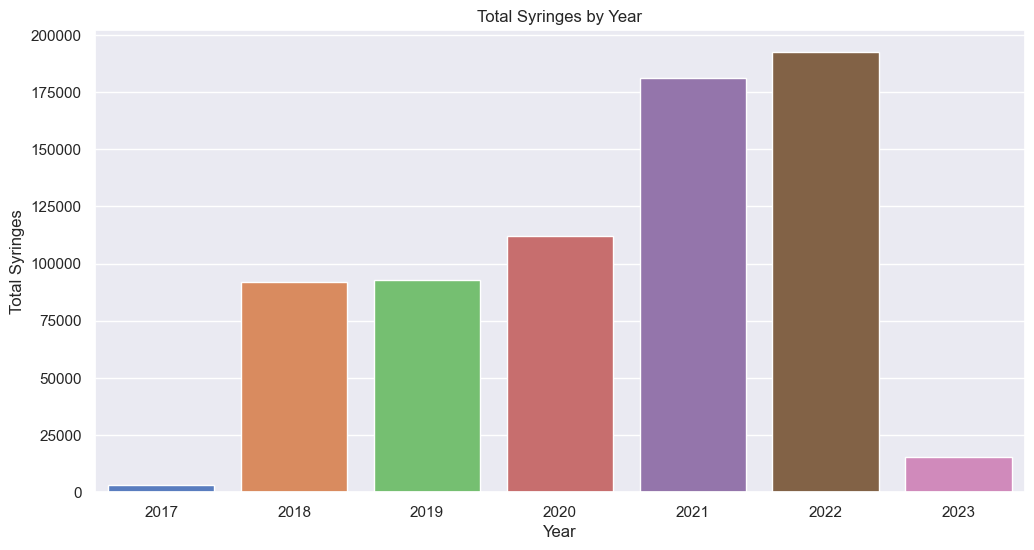

In [21]:
sns.set(rc={'figure.figsize': (12,6)})
sns.set_context("notebook")
sns.set_style("darkgrid")
figure2 = sns.barplot(x=pivot_table_1.index, y="total_syringes", data=pivot_table_1, palette="muted")
figure2.set(xlabel ="Year", ylabel = "Total Syringes", title ='Total Syringes by Year')

In [22]:
pivot_table_3 = pd.pivot_table(sy, index="borough", values=["ground_syringes", "total_syringes", "kiosk_syringes"], aggfunc="sum")
pivot_table_3

ground_syringes  kiosk_syringes  total_syringes
borough                                                       
Bronx                 350323.0         65062.0        415385.0
Manhattan             209636.0         64331.0        273967.0
Queens                    29.0             0.0            29.0
Staten Island            183.0             0.0           183.0

In [24]:
pivot_table_2 = pd.pivot_table(sy, index=["year", "property_type"], values=["ground_syringes", "kiosk_syringes", "total_syringes"], aggfunc="sum")
pivot_table_2

ground_syringes  kiosk_syringes  total_syringes
year property_type                                                 
2017 GREENST                   31.0             0.0            31.0
     PARK                    2246.0             0.0          2246.0
     ZONE                    1035.0             0.0          1035.0
2018 GREENST                   10.0             0.0            10.0
     PARK                   68182.0          9955.0         78137.0
     PLGD                    1130.0             0.0          1130.0
     ZONE                   12706.0             0.0         12706.0
2019 GREENST                  267.0             0.0           267.0
     PARK                   71164.0         21144.0         92308.0
     PLGD                     221.0             0.0           221.0
     ZONE                     174.0             0.0           174.0
2020 GREENST                   68.0             0.0            68.0
     PARK                   73115.0         38860.0        111975.0
     PLGD                      69.0             0.0            69.0
     ZONE                      69.0             0.0            69.0
2021 GREENST                  468.0             0.0           468.0
     PARK                   65573.0         31149.0         96722.0
     PLGD                    8722.0             0.0          8722.0
     ZONE                   75312.0             0.0         75312.0
2022 GREENST                 1108.0             0.0          1108.0
     PARK                   83441.0         27956.0        111397.0
     PLGD                    7375.0             0.0          7375.0
     ZONE                   72593.0             0.0         72593.0
2023 GREENST                   64.0             0.0            64.0
     PARK                    7074.0           329.0          7403.0
     PLGD                    2422.0             0.0          2422.0
     ZONE                    5532.0             0.0          5532.0

[Text(0.5, 25.0, 'Year'),
 Text(25.078125, 0.5, 'Total Syringes'),
 Text(0.5, 1.0, 'Total Syringes by Year')]

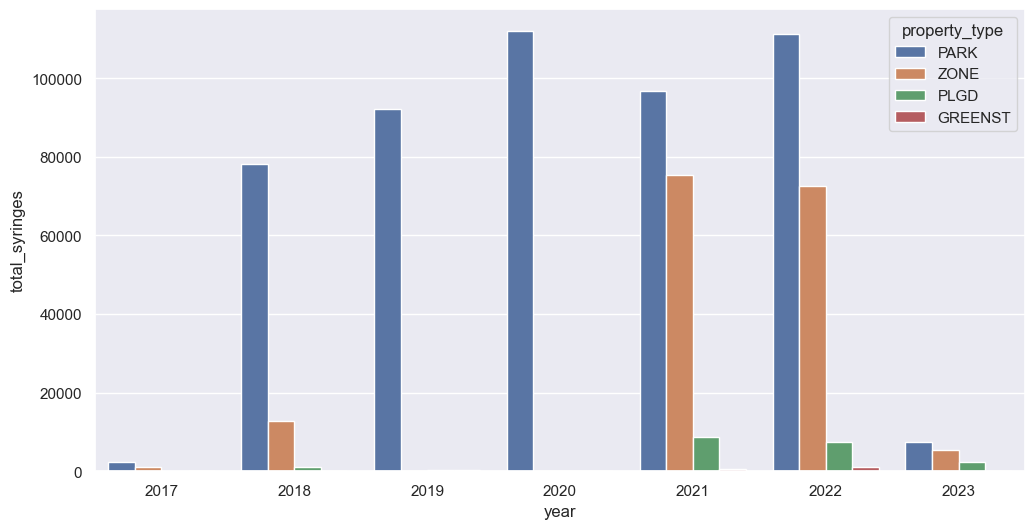

In [25]:
figure3 = sns.barplot(x='year', y='total_syringes', hue='property_type', data=sy, ci=None, estimator=sum)
figure2.set(xlabel ="Year", ylabel = "Total Syringes", title ='Total Syringes by Year')

<AxesSubplot:xlabel='year', ylabel='ground_syringes'>

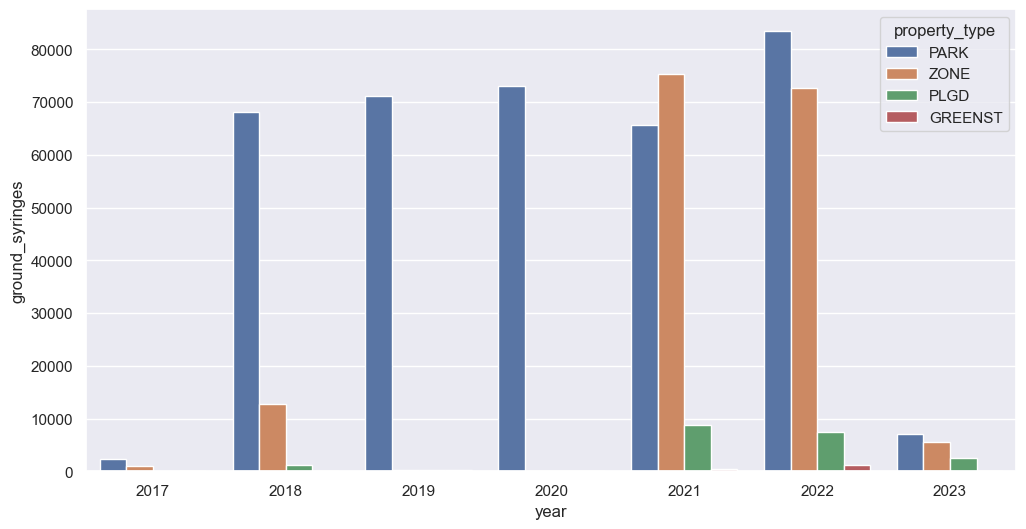

In [26]:
sns.barplot(x='year', y='ground_syringes', hue='property_type', data=sy, ci=None, estimator=sum)

In [ ]:
sns.barplot(x='year', y='kiosk_syringes', hue='property_type', data=sy, ci=None, estimator=sum)

Playground sharps seem to be doing better overall in this dataset; data collection methods may mask the true scale of the problem but if data collection methods are consistent then playgrounds may have weathered the problem in 2022 better. Kiosks are only available on Parks property.

<AxesSubplot:xlabel='year', ylabel='total_syringes'>

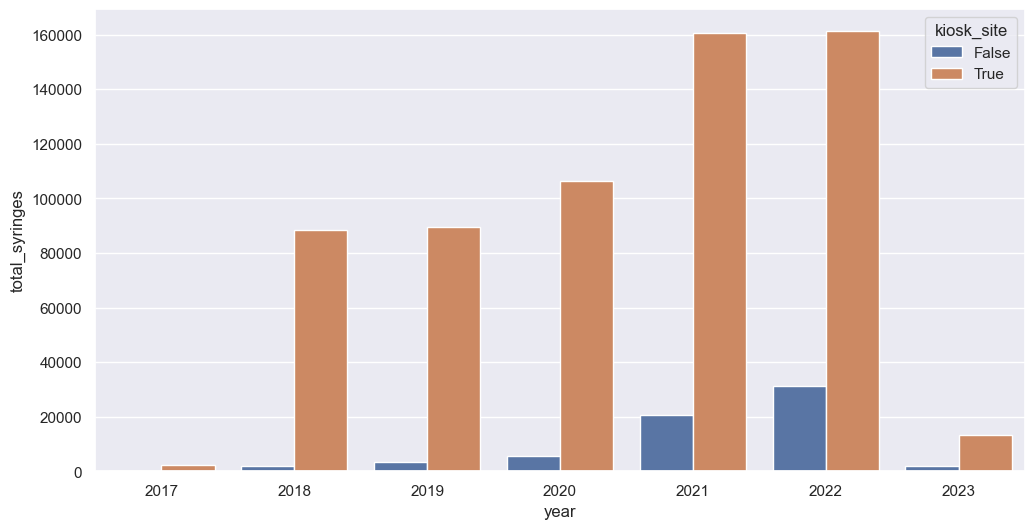

In [27]:
sns.barplot(x='year', y="total_syringes", hue='kiosk_site', data=sy, ci = None, estimator=sum)

The vast majority of sharps are collected at sites with kiosks available, even if they are not used. However, the collection of sharps at non-kiosk sites is increasing.

In [ ]:
#available if you want to look at the data by year and by week
#pivot_table_1a = pd.pivot_table(sy, index="year", columns = "week", values="total_syringes", aggfunc="sum")
#pivot_table_1a

<AxesSubplot:xlabel='year', ylabel='total_syringes'>

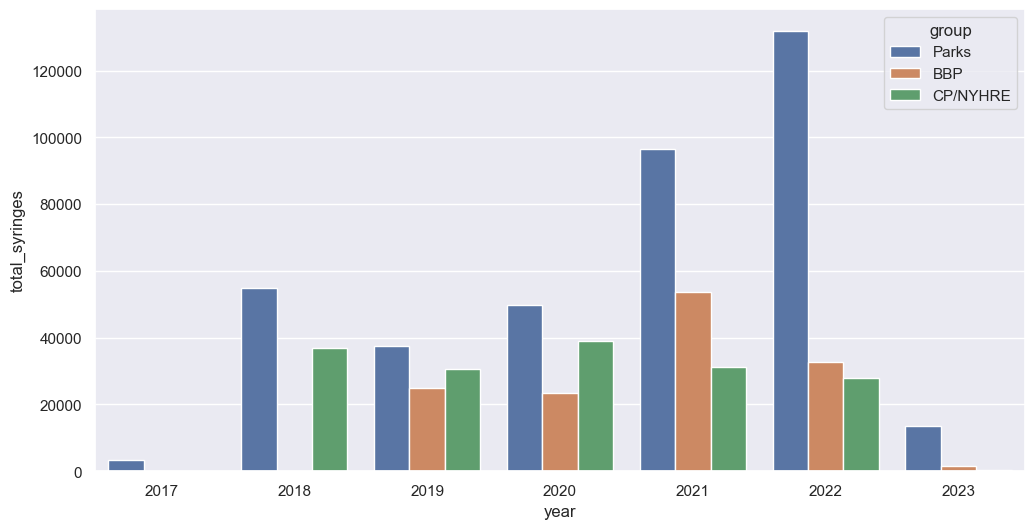

In [28]:
#let's try this with the whole dataset
sns.barplot(x='year', y="total_syringes", hue='group', data=sy, ci = None, estimator=sum)

The specialized Blood Borne Pathogens group was less involved in sharps collection 2022, after a high in 2021. Syringes recovered by nonprofits are down, while recoveries by regular Parks staff are way up.

<AxesSubplot:xlabel='collected_date', ylabel='total_syringes'>

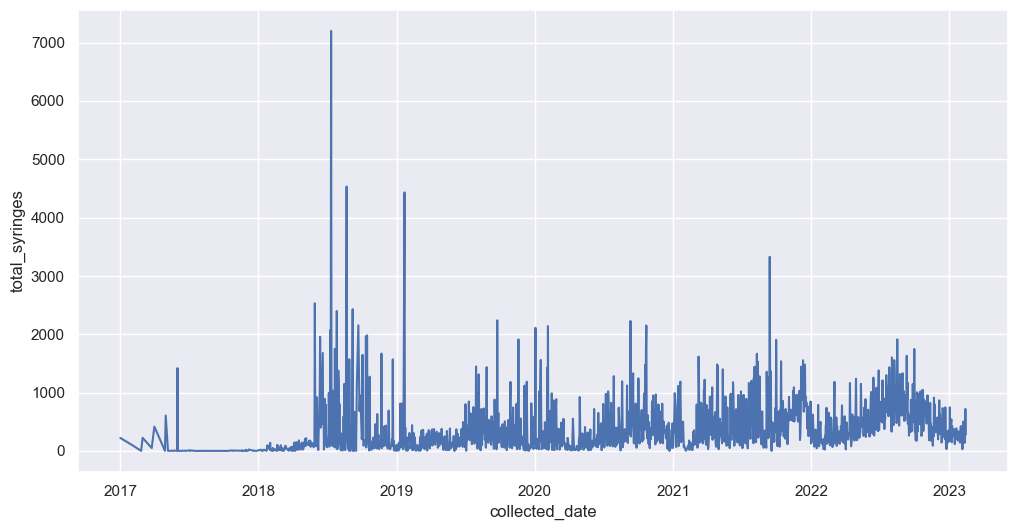

In [29]:
pivot_table_1b = pd.pivot_table(sy, index="collected_date", values=["ground_syringes", "kiosk_syringes", "total_syringes"], aggfunc="sum")
ax2 = sns.lineplot(x = pivot_table_1b.index, y = 'total_syringes', data = pivot_table_1b, ci = None, estimator=sum)
ax2

Early data is extremely spiky, but as the program matures there's a more steady collection of sharps. Early spikes and gaps in collection likely reflect growing pains in collection of data and collection of sharps.

### Impact of time

<AxesSubplot:xlabel='week', ylabel='total_syringes'>

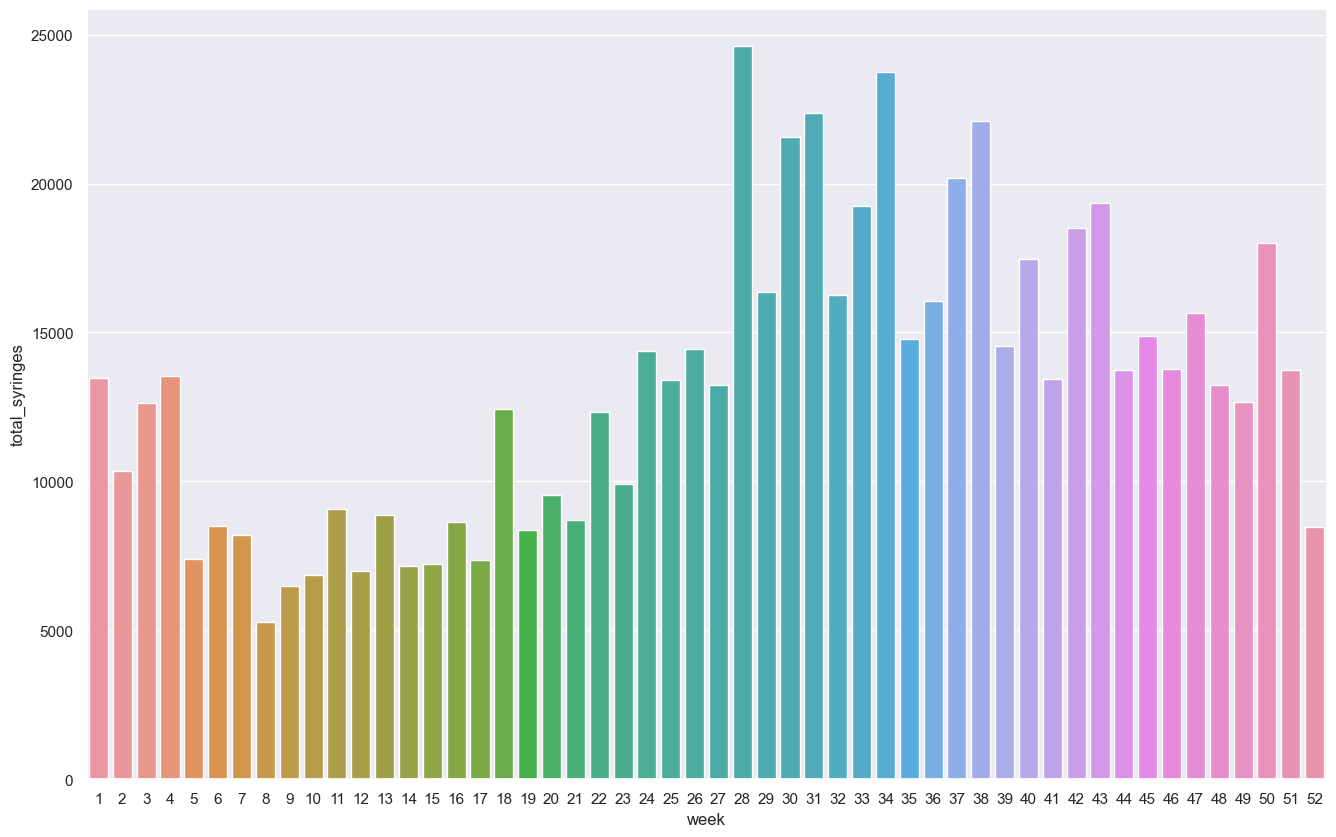

In [30]:
sns.set(rc={'figure.figsize': (16,10)})
sns.barplot(x = 'week', y = 'total_syringes', data = sy, ci = None, estimator = sum)


At first it appeared that the early weeks of the year represent calm times. However, it was not initially clear if that was due to fewer sharps being found or to issues with scheduling.

<AxesSubplot:xlabel='week', ylabel='count'>

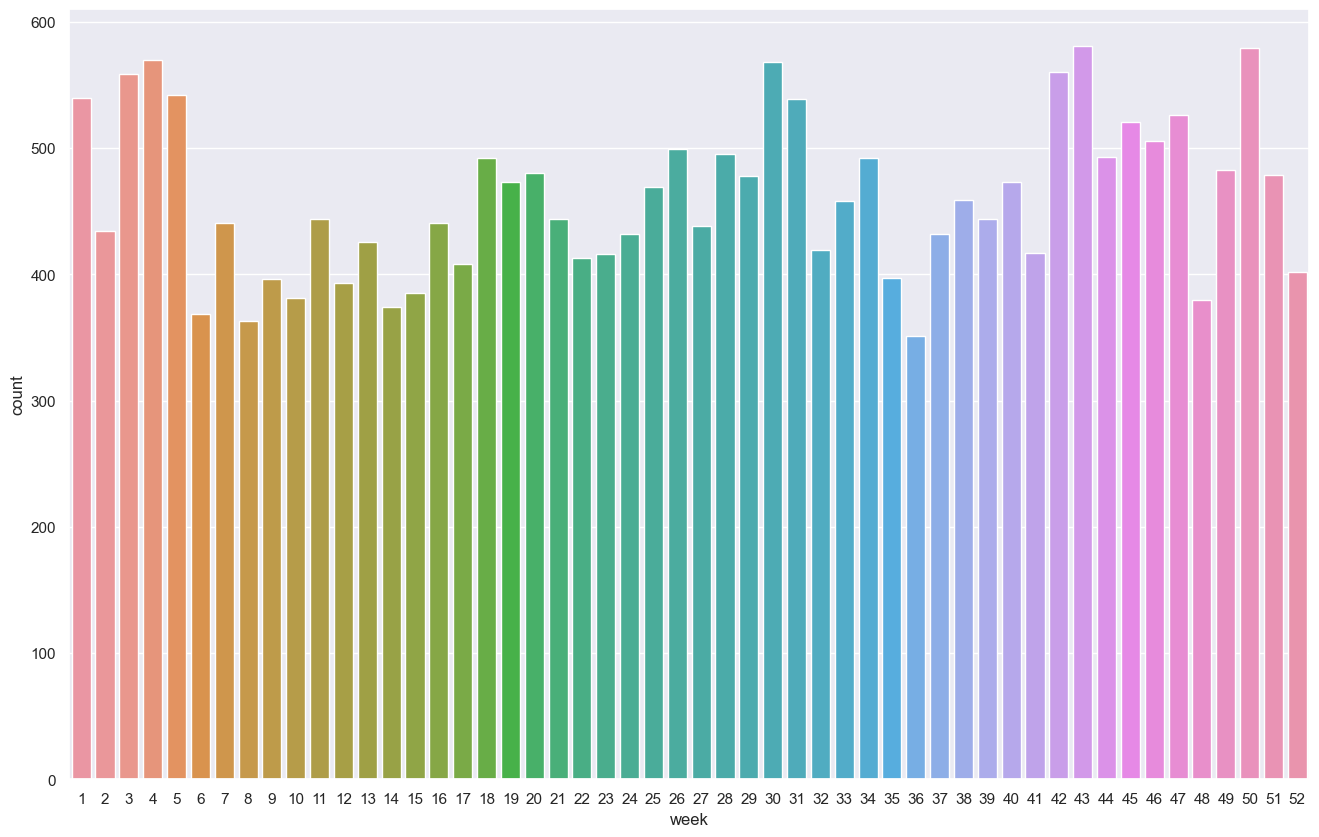

In [31]:
sns.countplot(data=sy, x='week')

While there are limits to what the data can tell us, the data distribution is significantly smoother when we consider counts of collection attempts. There is much less seasonal variation. However, it was important to break down our data by year to look for signs of the impact of the COVID-19 pandemic.

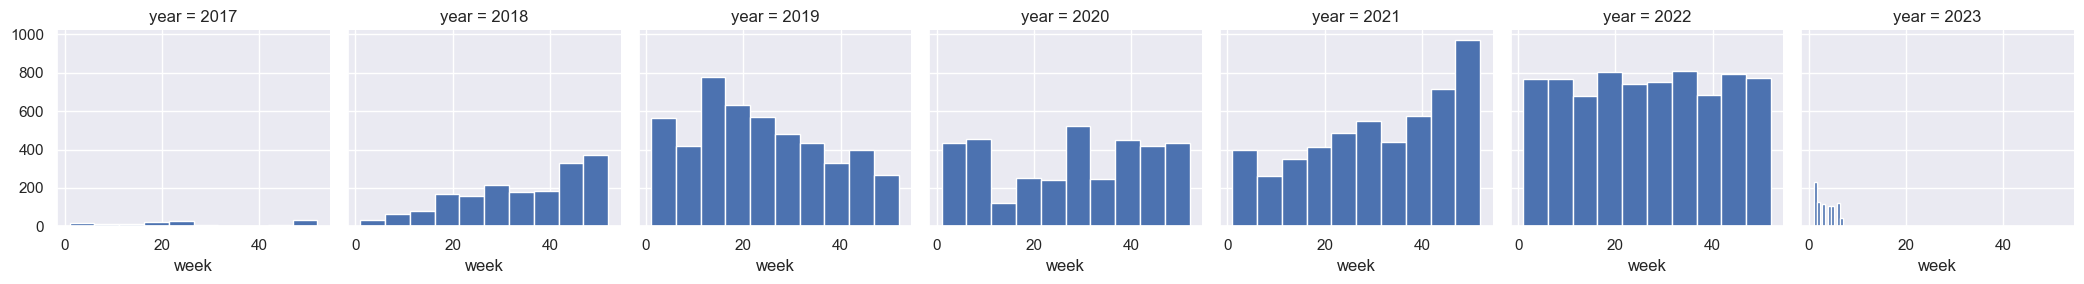

In [32]:
sns.FacetGrid(sy, col="year").map(plt.hist, "week")

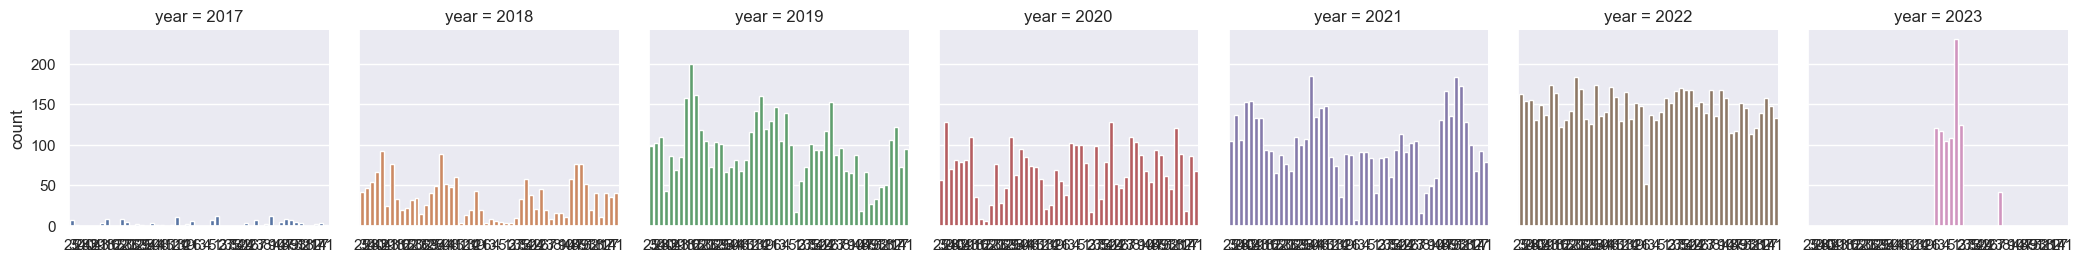

In [33]:
g = sns.FacetGrid(sy, col='year', hue='year')

# create bar graph
g = g.map(sns.countplot, 'week', order=sy.week.unique())
g.set(xlabel=None)
# show graph
plt.show()

Although there's weekly variation, there is consistent reporting from week to week - efforts occur year-round.
This suggests that variations in output are more likely to be attributable to effectiveness of efforts and the input of used needles, and less on whether or not collections occur.

However, we do note a disruption in collections in spring of 2020, and a large ramping up of collection efforts in 2021.

In [ ]:
#need a pivot table to aggregate ground, kiosk, and total syringes by 
#ax = sns.lineplot(x = 'Date', y = 'Revenue', data = df)

## Neighborhood impact

In [34]:
pivot_table_6 = pd.pivot_table(sy, index="precinct", values=["ground_syringes", "total_syringes", "kiosk_syringes"], aggfunc="sum").head(20)

In [35]:
pivot_table_6.sort_values(by=['total_syringes'], ascending = False)

ground_syringes  kiosk_syringes  total_syringes
precinct                                                 
40               195484.0         39767.0        235251.0
32                62811.0         63921.0        126732.0
34               105618.0             0.0        105618.0
33                19581.0           410.0         19991.0
2                 14267.0             0.0         14267.0
25                 5553.0             0.0          5553.0
6                  1813.0             0.0          1813.0
9                  1801.0             0.0          1801.0
23                 1519.0             0.0          1519.0
5                   467.0             0.0           467.0
18                  406.0             0.0           406.0
7                   226.0             0.0           226.0
3                   119.0             0.0           119.0
13                   94.0             0.0            94.0
1                    89.0             0.0            89.0
19                   11.0             0.0            11.0
10                    6.0             0.0             6.0
4                     5.0             0.0             5.0
20                    3.0             0.0             3.0
15                    3.0             0.0             3.0

<AxesSubplot:xlabel='precinct', ylabel='total_syringes'>

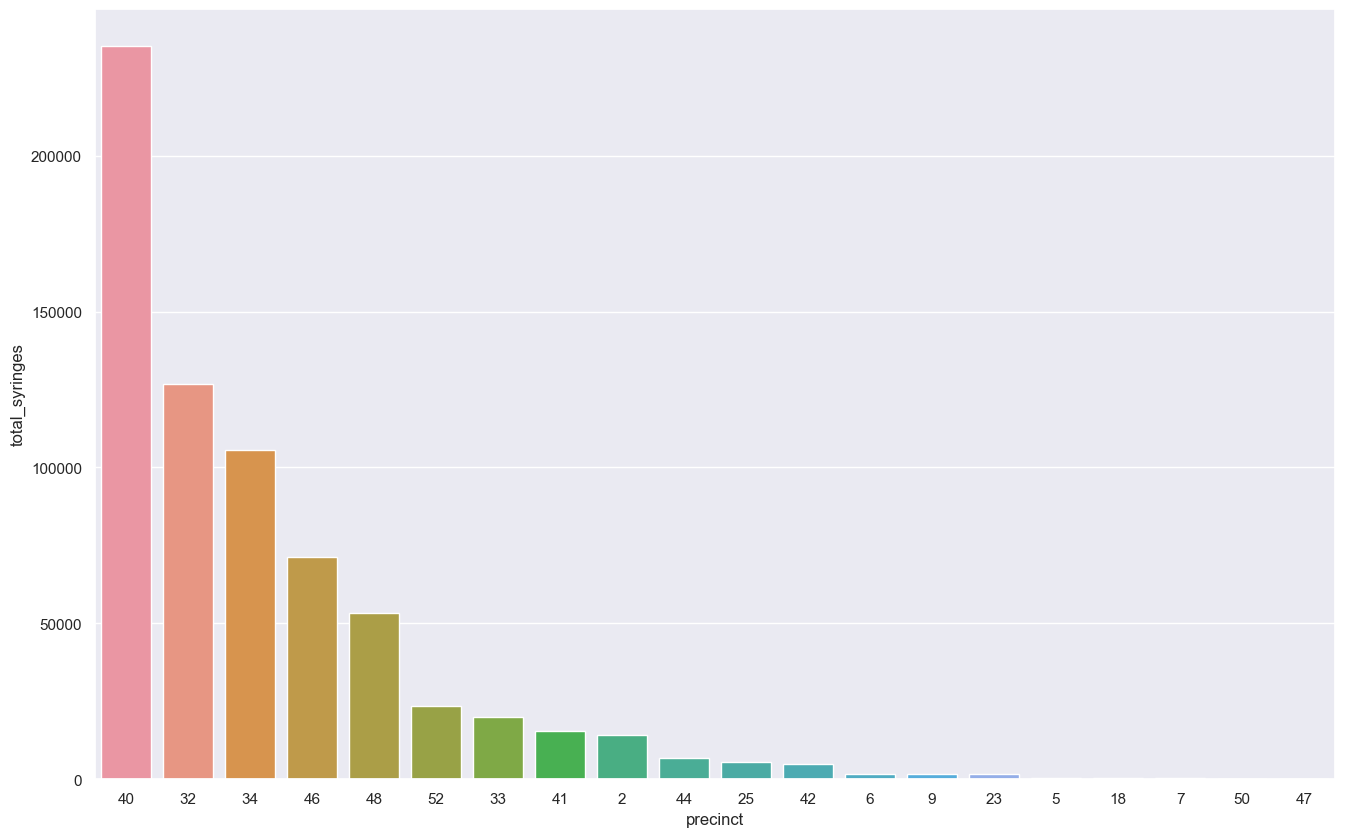

In [36]:
sy2 = sy[['precinct', 'total_syringes']].groupby('precinct').sum().sort_values('total_syringes', ascending=False).head(20)
sy2.reset_index()
sns.barplot(x=sy2.index, y="total_syringes", data=sy2, ci=None, order=sy2.sort_values('total_syringes',ascending = False).index)


The program is highly relevant in some precincts, where the average rate of sharps retrieval can approach 50,000 per year

In [37]:
pivot_table_7 = pd.pivot_table(sy1, index=["location", 'precinct'], values="total_syringes", aggfunc="sum")
pivot_table_7.sort_values(by=['total_syringes'], ascending = False).head(20)

total_syringes
location              precinct                
St. Mary's Park       40              176371.0
Highbridge Park       32              126646.0
                      34              103684.0
Walter Gladwin Park   48               51547.0
Richman (Echo) Park   46               39710.0
Patterson Playground  40               38068.0
Aqueduct Walk         46               27561.0
Highbridge Park       33               18748.0
Clark Playground      40               10679.0
Highbridge Park       2                 9540.0
Rose Hill Park        52                9517.0
Aqueduct Walk         52                7880.0
St. Mary's Park       2                 4727.0
Marcus Garvey Park    25                4178.0
Julio Carballo Fields 41                3889.0
Crotona Park          42                3510.0
Bill Rainey Park      41                3477.0
Willis Playground     40                3347.0
Franz Sigel Park      44                2896.0
St. James Park        52                2708.0

The scale of the effort can be masked because some locations are split between multiple jurisdictions. Highbridge Park has a higher total number of sharps retrieved, but two different precincts are responsible for public safety there.

In [38]:
sy3 = sy1[['location', 'ground_syringes', 'kiosk_syringes', 'total_syringes']].groupby('location').sum().sort_values('total_syringes', ascending=False).head(20)
sy3.reset_index()
sy3 = sy3.join(location_map.set_index('location'), on='location', how='left')

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

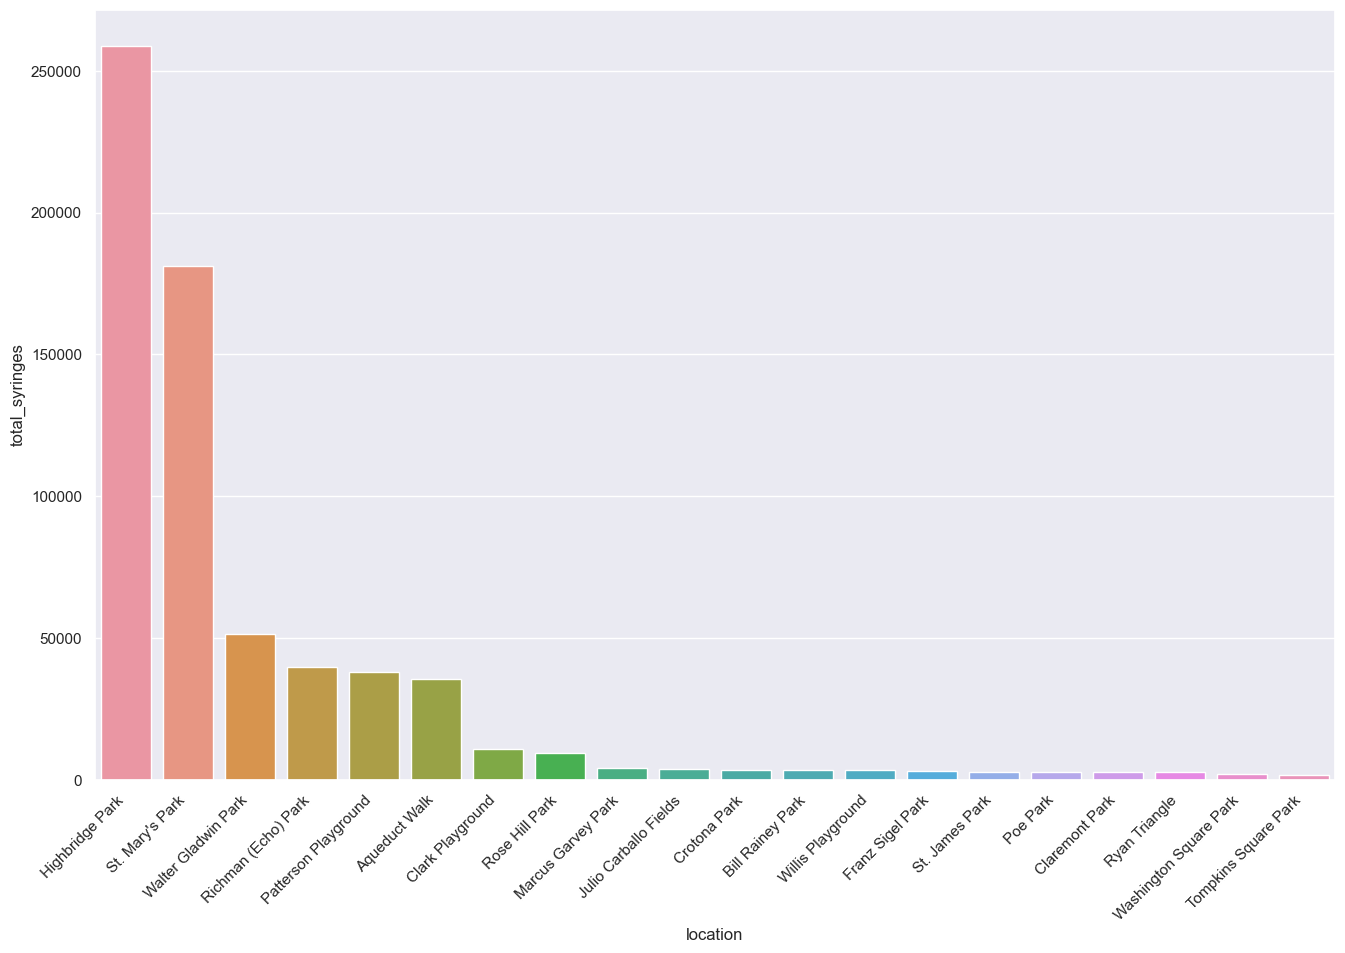

In [39]:
ax3=sns.barplot(x=sy3.index, y='total_syringes', data=sy3, ci=None)
plt.xticks(rotation=45)
plt.setp(ax3.xaxis.get_majorticklabels(), ha='right')

As with the precinct data, some locations are overwhelmed, some have nearly no sharps collected at all. Tompkins Square Park, often seen as a hotbed of drug use, has relatively few sharps collected compared to Highbridge.

In [40]:
sy4 = sy1[['location', 'year', 'ground_syringes', 'kiosk_syringes', 'total_syringes']].groupby(['location', 'year']).sum().sort_values('total_syringes', ascending=False).head(20)
sy4.reset_index()

location  year  ground_syringes  kiosk_syringes  \
0        Highbridge Park  2021          81226.0         18336.0   
1        Highbridge Park  2022          59947.0         18867.0   
2        St. Mary's Park  2022          46932.0          5384.0   
3        Highbridge Park  2020          30793.0         20453.0   
4        St. Mary's Park  2021          32870.0          7072.0   
5        St. Mary's Park  2018          33734.0           690.0   
6        St. Mary's Park  2020          21938.0          2517.0   
7        Highbridge Park  2019          17575.0          6165.0   
8        St. Mary's Park  2019          20353.0          2450.0   
9          Aqueduct Walk  2018          18343.0          4303.0   
10   Richman (Echo) Park  2022          18882.0           816.0   
11   Walter Gladwin Park  2019          11523.0          3352.0   
12  Patterson Playground  2019           7994.0          5435.0   
13   Walter Gladwin Park  2020           7066.0          5913.0   
14   Walter Gladwin Park  2018          10488.0           611.0   
15  Patterson Playground  2018           6875.0          3407.0   
16  Patterson Playground  2020           2318.0          5743.0   
17   Richman (Echo) Park  2021           6881.0          1003.0   
18   Walter Gladwin Park  2021           6209.0           992.0   
19         Aqueduct Walk  2022           5788.0             2.0   

    total_syringes  
0          99562.0  
1          78814.0  
2          52316.0  
3          51246.0  
4          39942.0  
5          34424.0  
6          24455.0  
7          23740.0  
8          22803.0  
9          22646.0  
10         19698.0  
11         14875.0  
12         13429.0  
13         12979.0  
14         11099.0  
15         10282.0  
16          8061.0  
17          7884.0  
18          7201.0  
19          5790.0

In [41]:
sy_grouped = sy.groupby(['location','year'], as_index=False).agg({'total_syringes':'sum', 'ground_syringes':'sum', 'kiosk_syringes':sum}).sort_values('total_syringes', ascending=False)
sy_grouped[sy_grouped['location'] == 'Highbridge Park']

location  year  total_syringes  ground_syringes  kiosk_syringes
291  Highbridge Park  2021         99562.0          81226.0         18336.0
292  Highbridge Park  2022         78814.0          59947.0         18867.0
290  Highbridge Park  2020         51246.0          30793.0         20453.0
289  Highbridge Park  2019         23740.0          17575.0          6165.0
293  Highbridge Park  2023          5256.0           5156.0           100.0

Highbridge Park is an anomaly for 2021-2022. It saw a significant decrease in ground syringes and total syringes, while kiosk syringes stayed roughly flat. 

In [ ]:
sy3

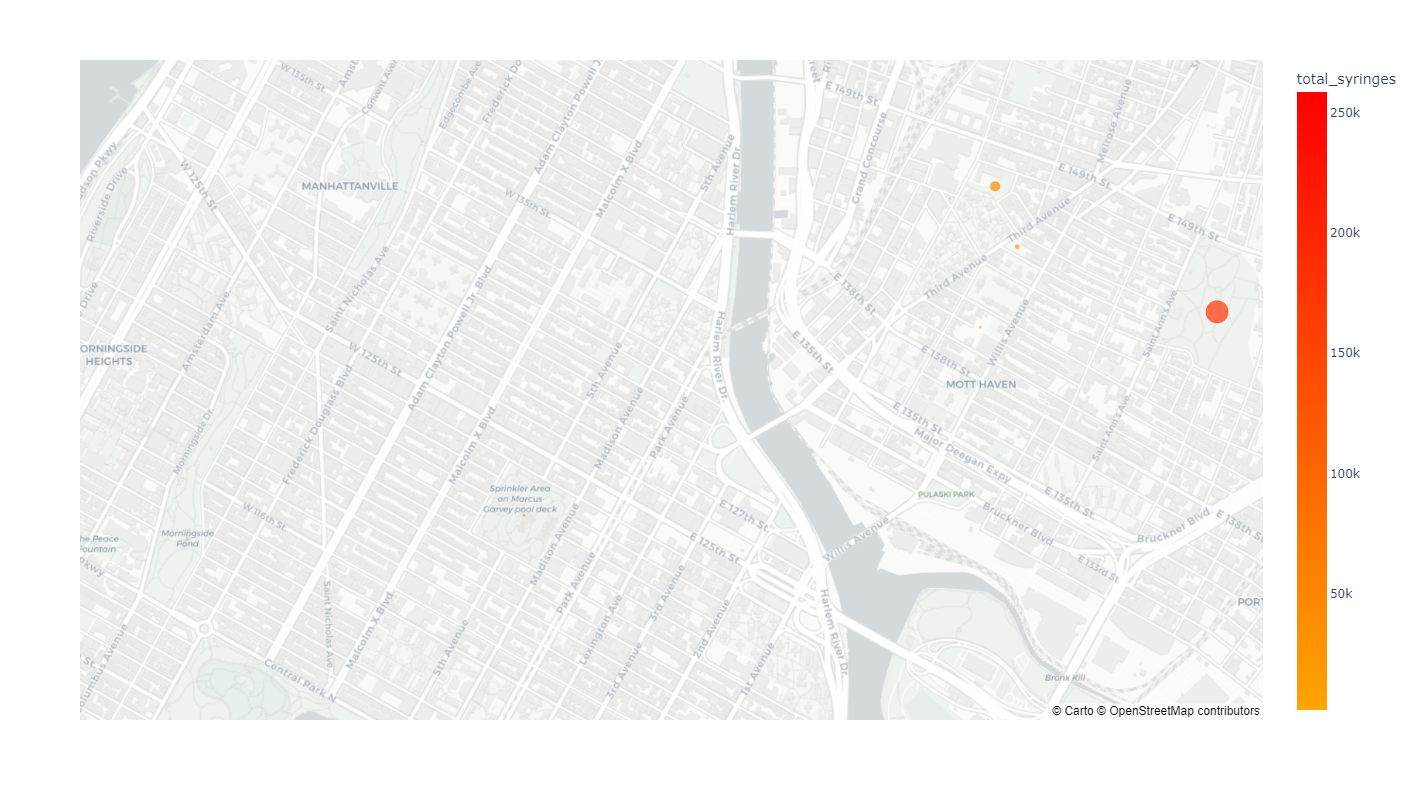

In [42]:
color_scale = [(0, 'orange'), (1,'red')]
fig = px.scatter_mapbox(sy3,
                        lat="latitude",
                        lon="longitude",
                        hover_data=[sy3.index, "ground_syringes", "kiosk_syringes"],
                        color="total_syringes",
                        color_continuous_scale=color_scale,
                        size="total_syringes",
                        zoom=9,
                        height=800,
                        width=1024)
fig.update_layout(mapbox_style="carto-positron")
fig.show()
#Some entries, like Tompkins Square Park, completely fall off the map due to being of infinitesimal scale compared to the leaders.

Again, hovering over the map reveals two major hotspots - Highbridge Park and St. Mary's Park. Hovering over them similarly shows that Highbridge has only about 30,000 more ground syringes than St. Mary's, despite having tens of thousands more total syringes. The answer is a higher use of kiosks, and the change in trajectory for Highbridge Park and St. Mary's in 2022 may have something to do with it.

<img src="Images/nyc_safe_injection_sites.jpg" alt="Safe Injection Sites" style="width: 900px;"/>

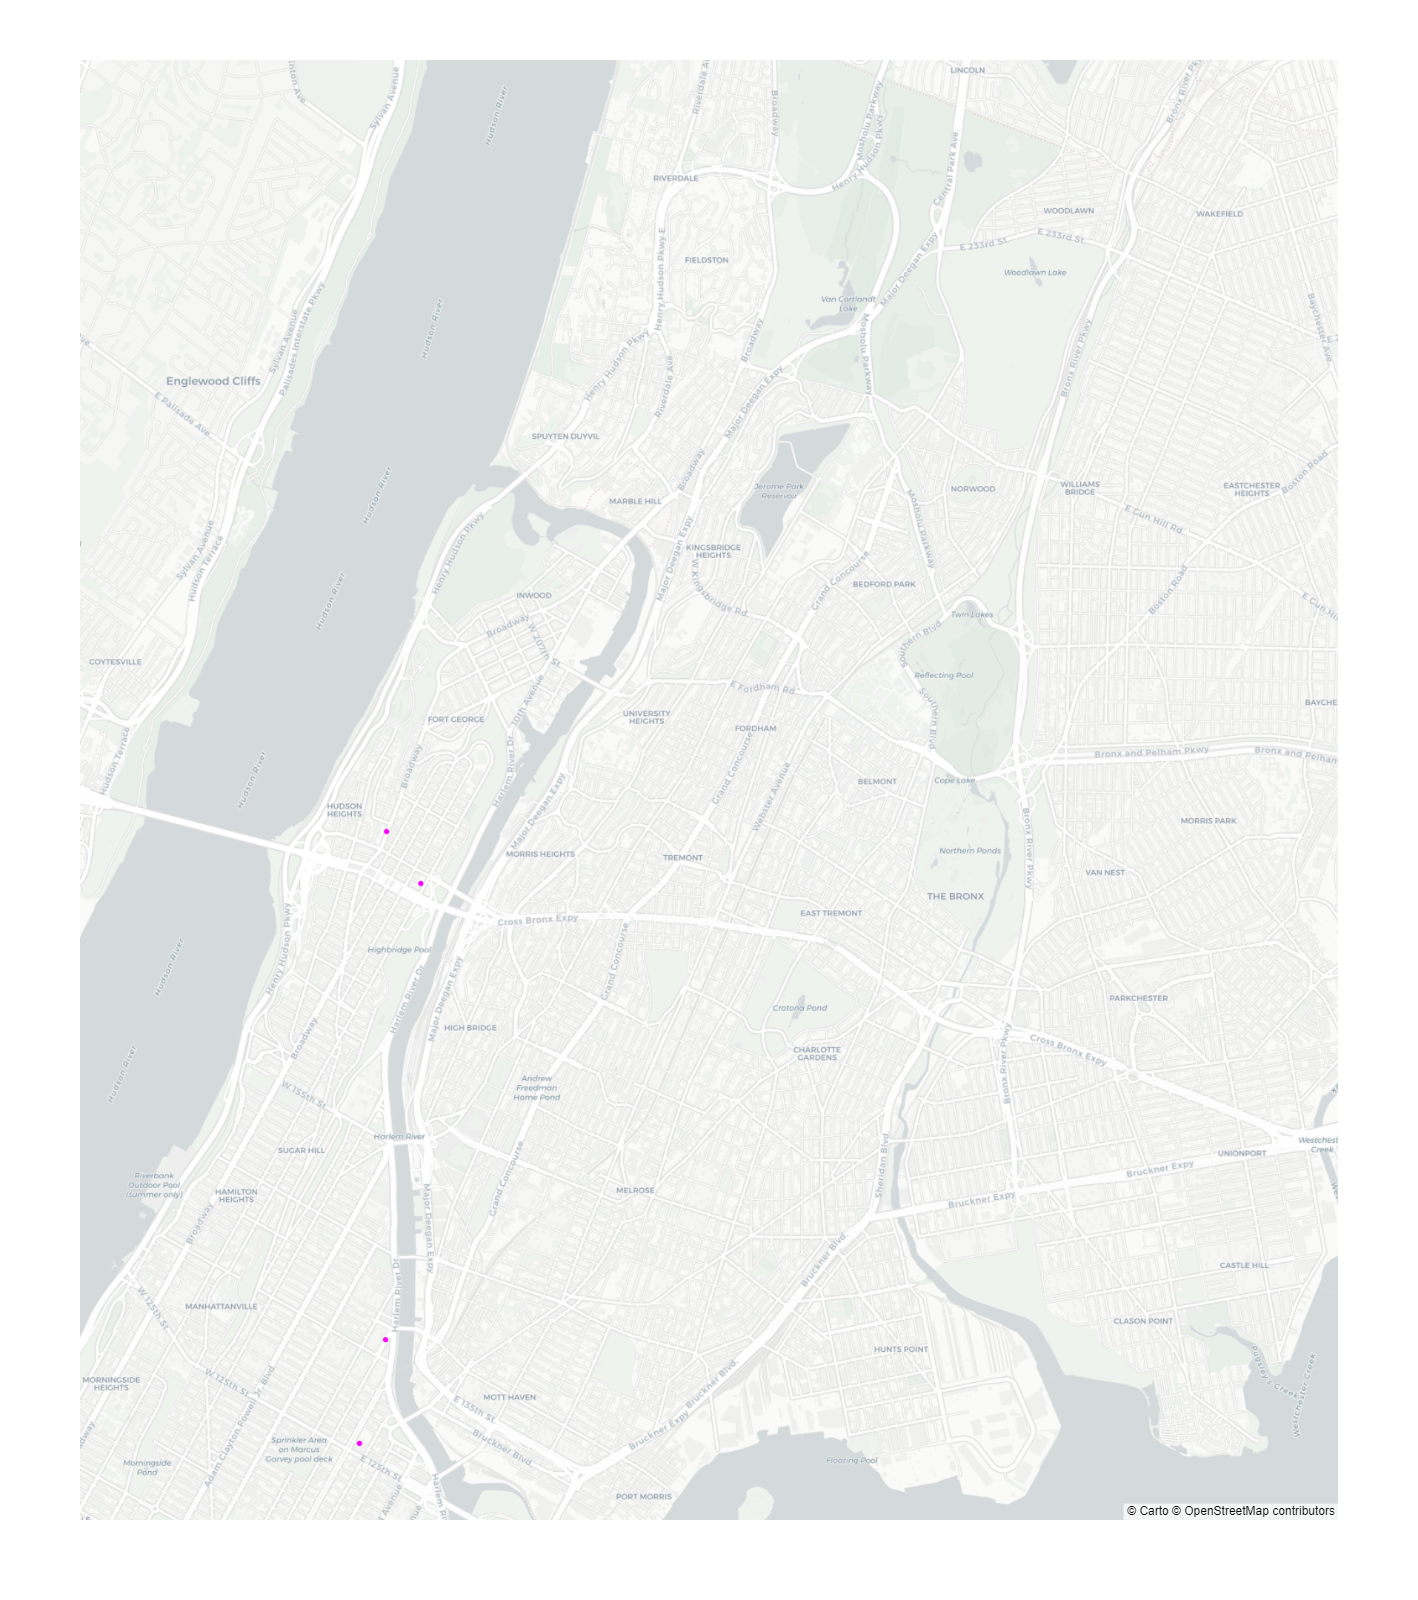

In [43]:
#create dataframe
police_locations = pd.DataFrame({'Name': ['40th Police Precinct', '32nd Police Precinct', '34th Police Precinct', 'Washington Heights CORNER Project', 'OnPoint NYC'],
                   'Latitude': [40.8133, 40.7871, 40.8515, 40.8476, 40.8055],
                   'Longitude': [-73.9352, -73.9199, -73.9351, -73.9317, -73.9378]
                  })

fig = px.scatter_mapbox(police_locations, lat='Latitude', lon='Longitude', hover_name='Name',
                        color_discrete_sequence=['fuchsia'], zoom=10, height=800)
fig.update_layout(mapbox_style='carto-positron')

fig.show()

## Conclusions

* Despite a continuation and consolidation of efforts, use of kiosks has dropped while ground syringe counts have increased.
* While certain properties, like playgrounds, are seeing fewer recovered needles, others are seeing major spikes. 
* The opening of a safe injection site in Washington Heights directly near the area of greatest need may have had an effect in reducing sharps recovery, by ofloading more of the burden to the safe injection site.
* However, the unexpected falloff in use of the needle kiosks while the overall sharps recovery burden grows suggests that the program is facing challenges and may not be adequate
* The OnPoint safe injection  center in East Harlem does not seem to be ideally suited to cover St. Mary's Park, and a new center may need to open in Mott Haven closer to the area of greatest burden

## Further research

* The lack of ground syringe recovery data from Brooklyn, Queens, and Staten Island means that it is difficult to draw conclusions about how these programs would work in those boroughs. Unified data collection would allow for better comparisons. If there are no sharps disposal kiosks provided by Parks in those areas, trends in the recovery of ground syringes could help tease out more of the effect of the kiosk program.
* Comparison with overall IV drug use indicators for the city as a whole could help elucidate if existing populations of drug users are deciding not to use the kiosks or if there is a change in the makeup of IV drug users that leads new arrivals to not use the kiosks
* Granular investigations using geographic coding to investigate the specific performance of kiosks in different areas and settings